# Tangles-CNN Training Notebook

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat_gmm import *

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
CUDA status:  True
CUDA memory max alloc:        0 MB


## Model Setup
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
exp_dir = "/home/pyushkevich/data/thon2019/exp01"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps
config = {
    "num_classes": 2,
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": 4,
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 16
    }
}

## Model instantiation and training

In [3]:
# Instantiate WildCat model
# data_dir = os.path.join(exp_dir, "patches")
data_dir = '/home/pyushkevich/data/thon2019/exp01/fold_HNL-11-15'

model = UNet_WSL_GMM(
    num_classes = config['num_classes'],
    mix_per_class=config['wildcat_upsample']['num_maps'], 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'])

In [4]:
# Loss and optimizer
# criterion = nn.MultiLabelSoftMarginLoss()

# We use BCE loss because network outputs are probabilities, and this loss
# does log clamping to prevent infinity or NaN in the gradients
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=config['wildcat_upsample']['batch_size'], 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])

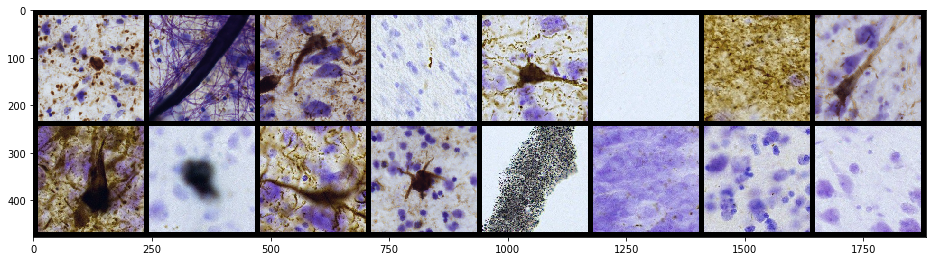

In [5]:
# Read a batch of data from the training data loader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img,label=next(iter(dataloaders_dict['train']))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label

In [6]:
# Load previous model?

In [7]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [8]:
# Try the model on one minibatch
with torch.set_grad_enabled(False):
    x = img.to(device)
    z = model(x)

z

tensor([[0.7013, 0.2987],
        [0.6321, 0.3679],
        [0.6456, 0.3544],
        [0.6227, 0.3773],
        [0.6775, 0.3225],
        [0.5129, 0.4871],
        [0.6164, 0.3836],
        [0.7186, 0.2814],
        [0.6685, 0.3315],
        [0.7145, 0.2855],
        [0.6066, 0.3934],
        [0.6950, 0.3050],
        [0.5971, 0.4029],
        [0.5436, 0.4564],
        [0.6773, 0.3227],
        [0.6268, 0.3732]], device='cuda:0')

In [9]:
# Define the criterion suitable for probabilities (which is what the model outputs)
# def wsl_gmm_criterion(z, labels_one_hot):
#    return torch.mean(- (torch.log(z) * labels_one_hot + torch.log(1-z) * (1-labels_one_hot)))
#
#class WSL_GMM_Loss():
#        
#    def forward(self, z, labels_one_hot):
#        return wsl_gmm_criterion(z, labels_one_hot)
#    
#criterion = wsl_gmm_criterion

In [9]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            mb = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], 2])
                labels_one_hot[:,0] = (labels==0)
                labels_one_hot[:,1] = (labels==1)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Print minimatch stats
                mb = mb + 1
                print('MB %04d  loss %f  corr %d' %
                      (mb, loss.item(), torch.sum(preds == labels.data).item()))
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
            # Save a copy of the model
            torch.save(model.state_dict(), '/tmp/checkpt_fc_%03d.pt' % (epoch,))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [91]:
# Train and evaluate
# model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])
model.load_state_dict(torch.load('/tmp/checkpt_fc_013.pt'))
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=6)

Epoch 0/5
----------
MB 0001  loss 0.191669  corr 15
MB 0002  loss 0.170241  corr 15
MB 0003  loss 0.229322  corr 15
MB 0004  loss 0.238405  corr 14
MB 0005  loss 0.113307  corr 16
MB 0006  loss 0.140076  corr 16
MB 0007  loss 0.120946  corr 16
MB 0008  loss 0.212329  corr 15
MB 0009  loss 0.203683  corr 15
MB 0010  loss 0.197714  corr 14
MB 0011  loss 0.559933  corr 12
MB 0012  loss 0.270378  corr 15
MB 0013  loss 0.152223  corr 15
MB 0014  loss 0.250035  corr 15
MB 0015  loss 0.225726  corr 15
MB 0016  loss 0.159025  corr 15
MB 0017  loss 0.158760  corr 15
MB 0018  loss 0.108397  corr 16
MB 0019  loss 0.265019  corr 15
MB 0020  loss 0.169884  corr 15
MB 0021  loss 0.602767  corr 11
MB 0022  loss 0.171985  corr 15
MB 0023  loss 0.228806  corr 15
MB 0024  loss 0.275416  corr 15
MB 0025  loss 0.379612  corr 14
MB 0026  loss 0.140111  corr 16
MB 0027  loss 0.119445  corr 16
MB 0028  loss 0.132185  corr 16
MB 0029  loss 0.137707  corr 16
MB 0030  loss 0.235476  corr 15
MB 0031  loss 0.150

In [20]:
# Load previous model?
model.load_state_dict(torch.load('/tmp/checkpt_fc_013.pt'))

<All keys matched successfully>

In [80]:
img,label=next(iter(dataloaders_dict['val']))
x = img.to(device)

labels_one_hot = torch.zeros([label.shape[0], 2])
labels_one_hot[:,0] = (label==0)
labels_one_hot[:,1] = (label==1)
labels_one_hot = labels_one_hot.to(device)

with torch.set_grad_enabled(False):
    y=model.softmax(model.unet(x))
    z=y
    for g in model.gmm: 
        z = g(z,x)
        
    # Apply spatial pooling to the probabilities (take average of max-values)
    z1 = model.spatial_pooling(z)
        
    # Apply the linear transformation to mix probabilities for classification
    z2 = model.fc_pooled(z1)
    sp = model.softmax_pooled(z2)
    
    cp = model.classwise_pooling(z) * 4
    
    # cp = model.classwise_pooling(z) * 4
    # sp = model.spatial_pooling(cp)
    
_, preds = torch.max(sp, 1)
criterion(sp, labels_one_hot).item(), sum(preds.cpu() == label).item()

(0.17723844945430756, 15)

In [81]:
with torch.set_grad_enabled(False):
    sp = model(x)


In [82]:
model.parameters

<bound method Module.parameters of UNet_WSL_GMM(
  (unet): {'UNet': {'in_channels': 3, 'out_channels': 8, 'n_blocks': 4, 'start_filters': 32, 'activation': 'relu', 'normalization': 'batch', 'conv_mode': 'same', 'dim': 2, 'up_mode': 'transposed'}}
  (softmax): Softmax(dim=1)
  (classwise_pooling): ClassWisePool (num_maps=4)
  (spatial_pooling): WildcatPool2d (kmax=0.02, kmin=0.0, alpha=0.7)
  (fc_pooled): Linear(in_features=8, out_features=2, bias=True)
  (softmax_pooled): Softmax(dim=1)
)>

In [83]:
sp, criterion(sp, labels_one_hot).item(), sum(preds.cpu() == label).item()

(tensor([[0.9193, 0.0807],
         [0.0659, 0.9341],
         [0.9298, 0.0702],
         [0.0744, 0.9256],
         [0.8860, 0.1140],
         [0.0813, 0.9187],
         [0.8816, 0.1184],
         [0.3200, 0.6800],
         [0.8786, 0.1214],
         [0.0715, 0.9285],
         [0.8616, 0.1384],
         [0.9344, 0.0656],
         [0.9133, 0.0867],
         [0.6818, 0.3182],
         [0.0961, 0.9039],
         [0.9351, 0.0649]], device='cuda:0'), 0.17723844945430756, 15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


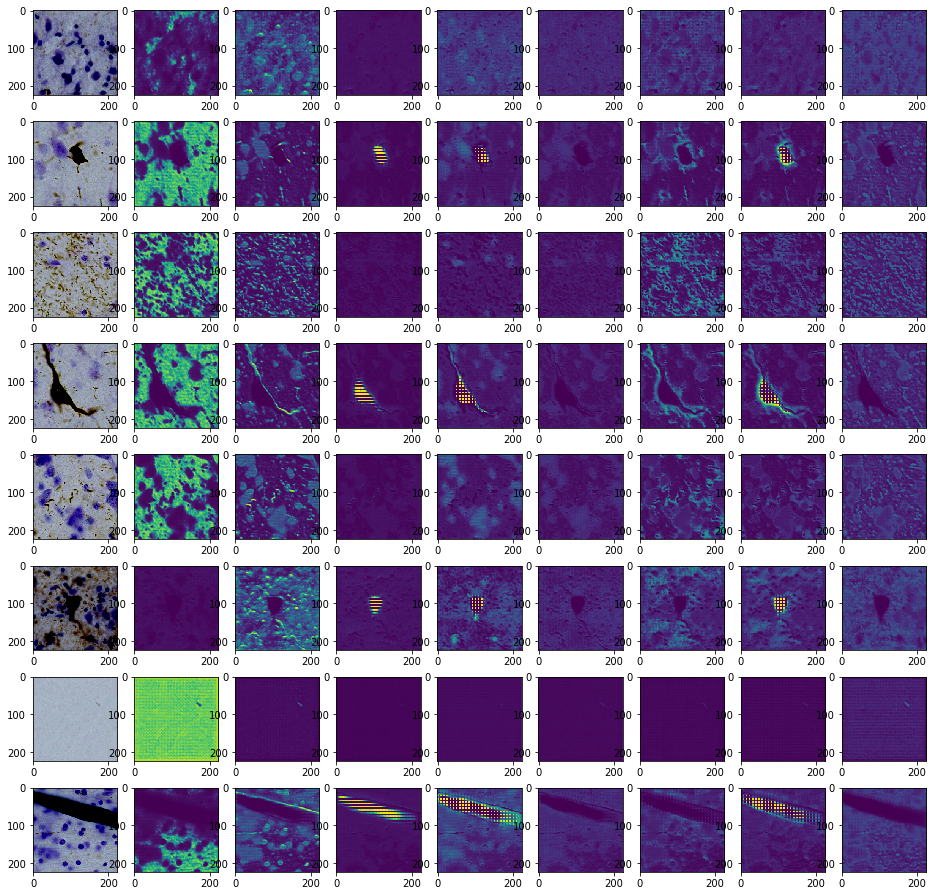

In [84]:
plt.figure(figsize=(16,16))
for b in range(8):
    plt.subplot(8, 9, 9*b + 1)
    plt.imshow(x[b,:,:,:].permute(1,2,0).detach().cpu().numpy() * 0.3)
    for k in range(8):
        plt.subplot(8, 9, 9*b + k + 2)
        plt.imshow(y[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


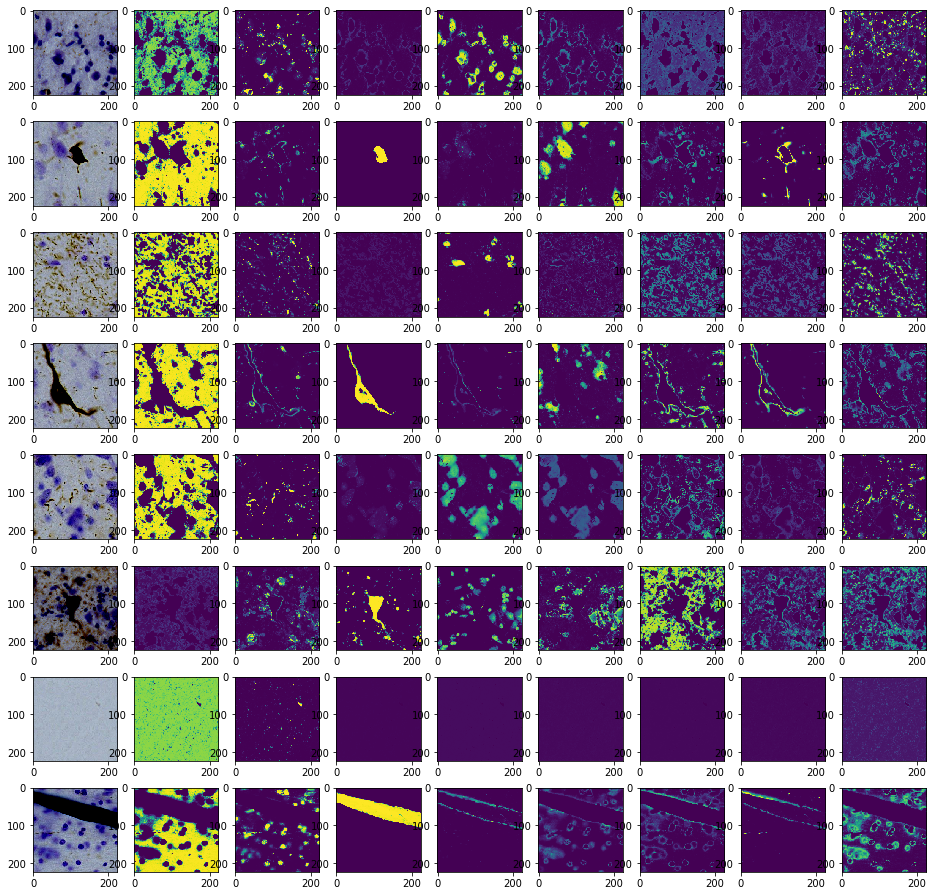

In [86]:
plt.figure(figsize=(16,16))
for b in range(8):
    plt.subplot(8, 9, 9*b + 1)
    plt.imshow(x[b,:,:,:].permute(1,2,0).detach().cpu().numpy() * 0.3)
    for k in range(8):
        plt.subplot(8, 9, 9*b + k + 2)
        plt.imshow(z[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=1)

In [87]:
model.fc_pooled.weight.shape, model.fc_pooled.bias.shape, z.shape

(torch.Size([2, 8]), torch.Size([2]), torch.Size([16, 8, 224, 224]))

In [88]:
cp = torch.softmax((torch.matmul(z.permute(0,2,3,1), model.fc_pooled.weight.permute(1,0)) + model.fc_pooled.bias.view(1,1,1,2)).permute(0,3,1,2),1)

In [89]:
for a,b in enumerate(model.fc_pooled.named_parameters()):
    print(a,b)

0 ('weight', Parameter containing:
tensor([[ 0.5291,  0.3766, -1.5611,  0.4017, -0.9103, -0.2741, -0.3960,  0.1733],
        [-0.6072, -0.5644,  1.0817, -0.5246,  0.6031,  0.3434,  0.8169, -0.1932]],
       device='cuda:0', requires_grad=True))
1 ('bias', Parameter containing:
tensor([ 0.3145, -0.5095], device='cuda:0', requires_grad=True))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


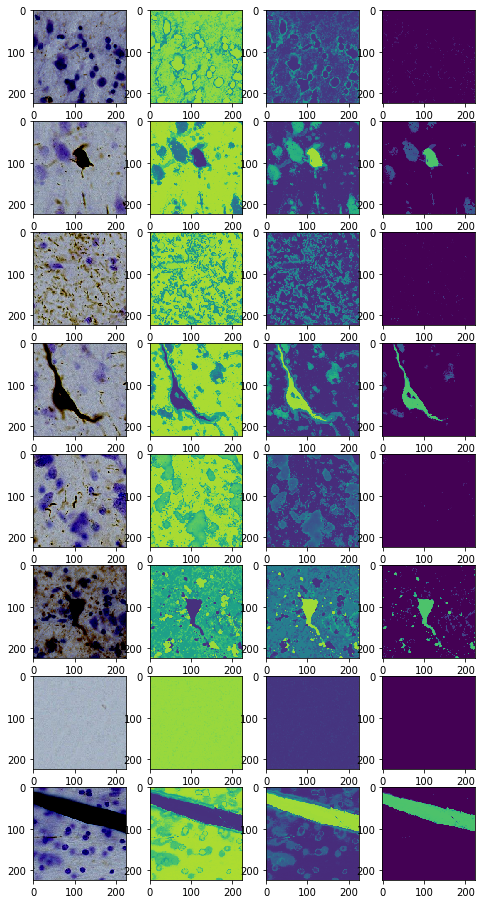

In [90]:
plt.figure(figsize=(8,16))
for b in range(8):
    plt.subplot(8, 4, 4*b + 1)
    plt.imshow(x[b,:,:,:].permute(1,2,0).detach().cpu().numpy() * 0.3)
    for k in range(2):
        plt.subplot(8, 4, 4*b + k + 2)
        plt.imshow(cp[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=1)
    plt.subplot(8, 4, 4*b + k + 3)
    plt.imshow(cp[b,1,:,:].detach().cpu().numpy(), vmin=0.5, vmax=1)

In [78]:
model.spatial_pooling

WildcatPool2d (kmax=0.02, kmin=0.0, alpha=0.7)

## Export model

In [18]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.state_dict(), os.path.join(model_dir, "wildcat_upsample.dat"))

# Save the configuration
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Model performance over epochs

In [34]:
plt.plot(hist)

NameError: name 'hist' is not defined

In [12]:
del model_ft
torch.cuda.empty_cache()

In [13]:
!nvidia-smi

Mon Dec 14 16:12:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    49W / 250W |   2079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------